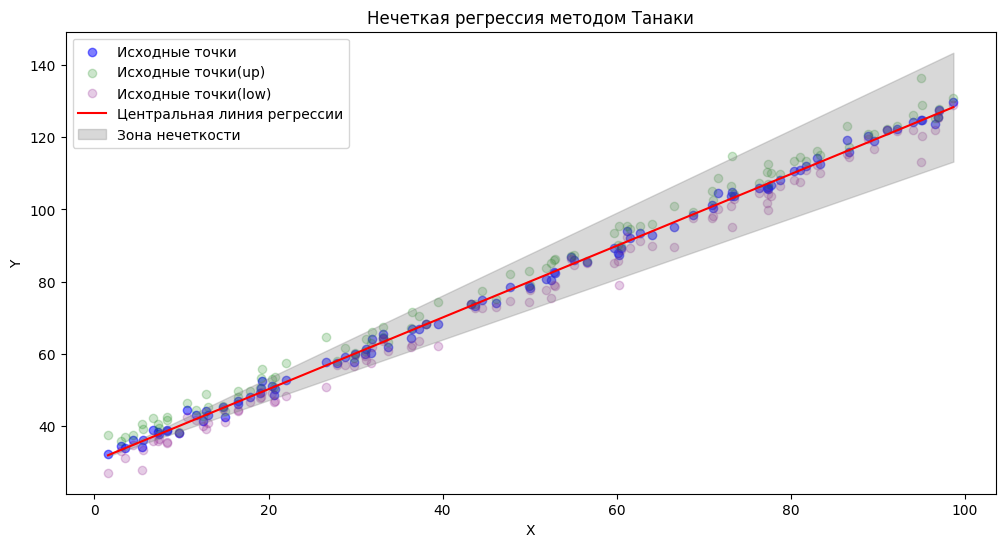

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Генерация нечетких треугольных данных
def generate_fuzzy_triangular_data(n_samples=100, a=1, b=30, noise_sigma=3, random_state=42):
    np.random.seed(random_state)
    X = np.random.uniform(1, 100, size=(n_samples, 1))
    y_central = a * X.flatten() + b + np.random.normal(0, noise_sigma/2, n_samples) # Центральные значения || добавлены шумы, чтобы не прямая
    noise = np.random.normal(0, noise_sigma, n_samples)
    y_upper = y_central + abs(noise)
    y_lower = y_central - abs(noise)
    return X, y_central, y_lower, y_upper

# Реализация нечеткой регрессии
def tanaka_fuzzy_regression(X, y_lower, y_upper):
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Добавляем свободный член
    n_vars = X.shape[1]
    
    # Обычная регрессия для центральных коэффициентов
    beta_c = np.linalg.lstsq(X, (y_lower + y_upper) / 2, rcond=None)[0]
    
    # Вычисление ширины нечеткости
    c = np.hstack([np.zeros(n_vars), np.ones(n_vars)])
    A_ub = np.vstack([
        np.hstack([-X, -np.abs(X)]),  # -beta_c - beta_w * x <= -y_lower
        np.hstack([X, -np.abs(X)])  # beta_c + beta_w * x >= y_upper
    ])
    b_ub = np.hstack([-y_lower, y_upper])
    
    result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, method="highs")
    if result.success:
        beta_w = result.x[n_vars:]
        return beta_c, beta_w
    else:
        raise ValueError("Оптимизация не удалась")

# Генерация данных
X, y_central, y_lower, y_upper = generate_fuzzy_triangular_data()

# Применение метода
beta_c, beta_w = tanaka_fuzzy_regression(X, y_lower, y_upper)

# Визуализация результатов
X_sorted = np.sort(X, axis=0)
y_pred_central = np.hstack([np.ones((X_sorted.shape[0], 1)), X_sorted]) @ beta_c
y_pred_upper = y_pred_central + np.hstack([np.ones((X_sorted.shape[0], 1)), X_sorted]) @ beta_w
y_pred_lower = y_pred_central - np.hstack([np.ones((X_sorted.shape[0], 1)), X_sorted]) @ beta_w

plt.figure(figsize=(12, 6))
plt.scatter(X, y_central, label='Исходные точки', color='blue', alpha=0.5)
plt.scatter(X, y_upper, label='Исходные точки(up)', color='green', alpha=0.2)
plt.scatter(X, y_lower, label='Исходные точки(low)', color='purple', alpha=0.2)
plt.plot(X_sorted, y_pred_central, label='Центральная линия регрессии', color='red')
plt.fill_between(X_sorted.flatten(), y_pred_lower, y_pred_upper, color='gray', alpha=0.3, label='Зона нечеткости')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Нечеткая регрессия методом Танаки')
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Оценка качества модели
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2


indexes = np.argsort(X, axis=0)[:, 0]

# Оценка нечеткой регрессии
mae_fuzzy, mse_fuzzy, r2_fuzzy = evaluate_model(y_central[indexes], y_pred_central)
print(f"Нечеткая регрессия: MAE = {mae_fuzzy}, MSE = {mse_fuzzy}, R2 = {r2_fuzzy}")

mae_fuzzy, mse_fuzzy, r2_fuzzy = evaluate_model(y_upper[indexes], y_pred_upper)
print(f"Нечеткая регрессия(up): MAE = {mae_fuzzy}, MSE = {mse_fuzzy}, R2 = {r2_fuzzy}")

mae_fuzzy, mse_fuzzy, r2_fuzzy = evaluate_model(y_lower[indexes], y_pred_lower)
print(f"Нечеткая регрессия(low): MAE = {mae_fuzzy}, MSE = {mse_fuzzy}, R2 = {r2_fuzzy}")


Нечеткая регрессия: MAE = 1.0515640079456634, MSE = 1.8148152689258703, R2 = 0.997861417348317
Нечеткая регрессия(up): MAE = 5.66268592091866, MSE = 47.17990000831606, R2 = 0.9450074663015858
Нечеткая регрессия(low): MAE = 5.370014674492565, MSE = 47.242292466588616, R2 = 0.94425627706898
